# Grado en Robótica - Visión Artificial
## Práctica 5: Reconocimiento geométrico de formas 2D con clasificadores Bayesianos
### Autor: Adrián Losada Álvarez

# Tarea 1: Reconocedores basados en descriptores de contorno

### Importamos las librerías necesarias

In [408]:
#Importamos las librerias precisas
import cv2
import numpy as np
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

### Creamos un conjunto de siluetas simples sin textura en 2D con algunas de las figuras que proporciona paint

In [409]:
data_path = './data/figuras_modificadas/'
dirs_figuras = os.listdir(data_path)

### Este fragmento de código es simplemente para borrar los archivos creados en ejecuciones anteriores y que no cree problemas al ejecutarlos de nuevo

In [420]:
for figure_type in dirs_figuras:
    path = os.path.join(data_path, figure_type)
    archs_txt = [arch for arch in os.listdir(path) if arch.endswith('.txt')]

    for arch in archs_txt:
        complete_path = os.path.join(path, arch)
        os.remove(complete_path)

Binarizamos las imágenes

In [411]:
for figure_type in dirs_figuras:
    list_images = os.listdir(data_path+figure_type)
    for image in list_images:
    # Bucle para procesar cada imagen en la ruta especificada
        # Comprobamos si la imagen es en formato PNG y que no esta
        if image.endswith('.png'):
            # Leemos la imagen
            img = cv2.imread(os.path.join(data_path+figure_type, image), cv2.IMREAD_GRAYSCALE)

            # Binarizamos la imagen
            _, bin_img = cv2.threshold(img, 255//2, 255, cv2.THRESH_BINARY)

            # Guardamos la imagen binarizada
            cv2.imwrite(os.path.join(data_path+figure_type, image), bin_img)

### Implementamos la función radial (FR)

In [412]:
def FR(points):
    pad_size = 3  # Tamaño del relleno para los cálculos de gradiente
    # Se añade un relleno a los puntos para evitar problemas al calcular los gradientes en los bordes
    padded_points = np.pad(points, ((pad_size, pad_size), (0, 0)), 'wrap')

    # Cálculo de las derivadas en x e y (dx, dy) usando los puntos rellenados
    dx = np.gradient(padded_points[:, 0])  # Derivada en x
    ddx = np.gradient(dx)  # Segunda derivada en x
    dy = np.gradient(padded_points[:, 1])  # Derivada en y
    ddy = np.gradient(dy)  # Segunda derivada en y

    # Cálculo de la curvatura usando las derivadas obtenidas
    fr = np.abs(ddx[pad_size:-pad_size] * dy[pad_size:-pad_size] - dx[pad_size:-pad_size] * ddy[pad_size:-pad_size]) / np.power(dx[pad_size:-pad_size] * dx[pad_size:-pad_size] + dy[pad_size:-pad_size] * dy[pad_size:-pad_size], 3 / 2)

    return fr  # Retorna la curvatura calculada

Probamos la función implementada

Imagen: estrella0.png, Valores: [0.07333333 0.01097995 0.08120417 0.00991462 0.08212214 0.01303155
 0.05523388 0.01241128 0.08120417 0.01097995]
Imagen: estrella1.png, Valores: [0.05379639 0.00634606 0.0474334  0.00600057 0.05252231 0.00726392
 0.04140939 0.00706888 0.04447539 0.00654139]
Imagen: estrella2.png, Valores: [0.11183117 0.02179151 0.07826415 0.0155     0.115      0.01705259
 0.11630599 0.01582492 0.09427005 0.01592798]
Imagen: estrella4.png, Valores: [0.10583052 0.02486767 0.10206867 0.02050965 0.1470067  0.01682382
 0.1314868  0.00670024 0.00087841 0.16301171 0.01802498]
Imagen: estrella3.png, Valores: [0.05353147 0.00549505 0.04286803 0.00744862 0.05189109 0.00724107
 0.04359822 0.00609521 0.04662743 0.0083826 ]
Imagen: estrella5.png, Valores: [0.04690764 0.00678076 0.0535588  0.0071459  0.04360102 0.00750735
 0.05363287 0.0063428  0.05195378 0.00741465]


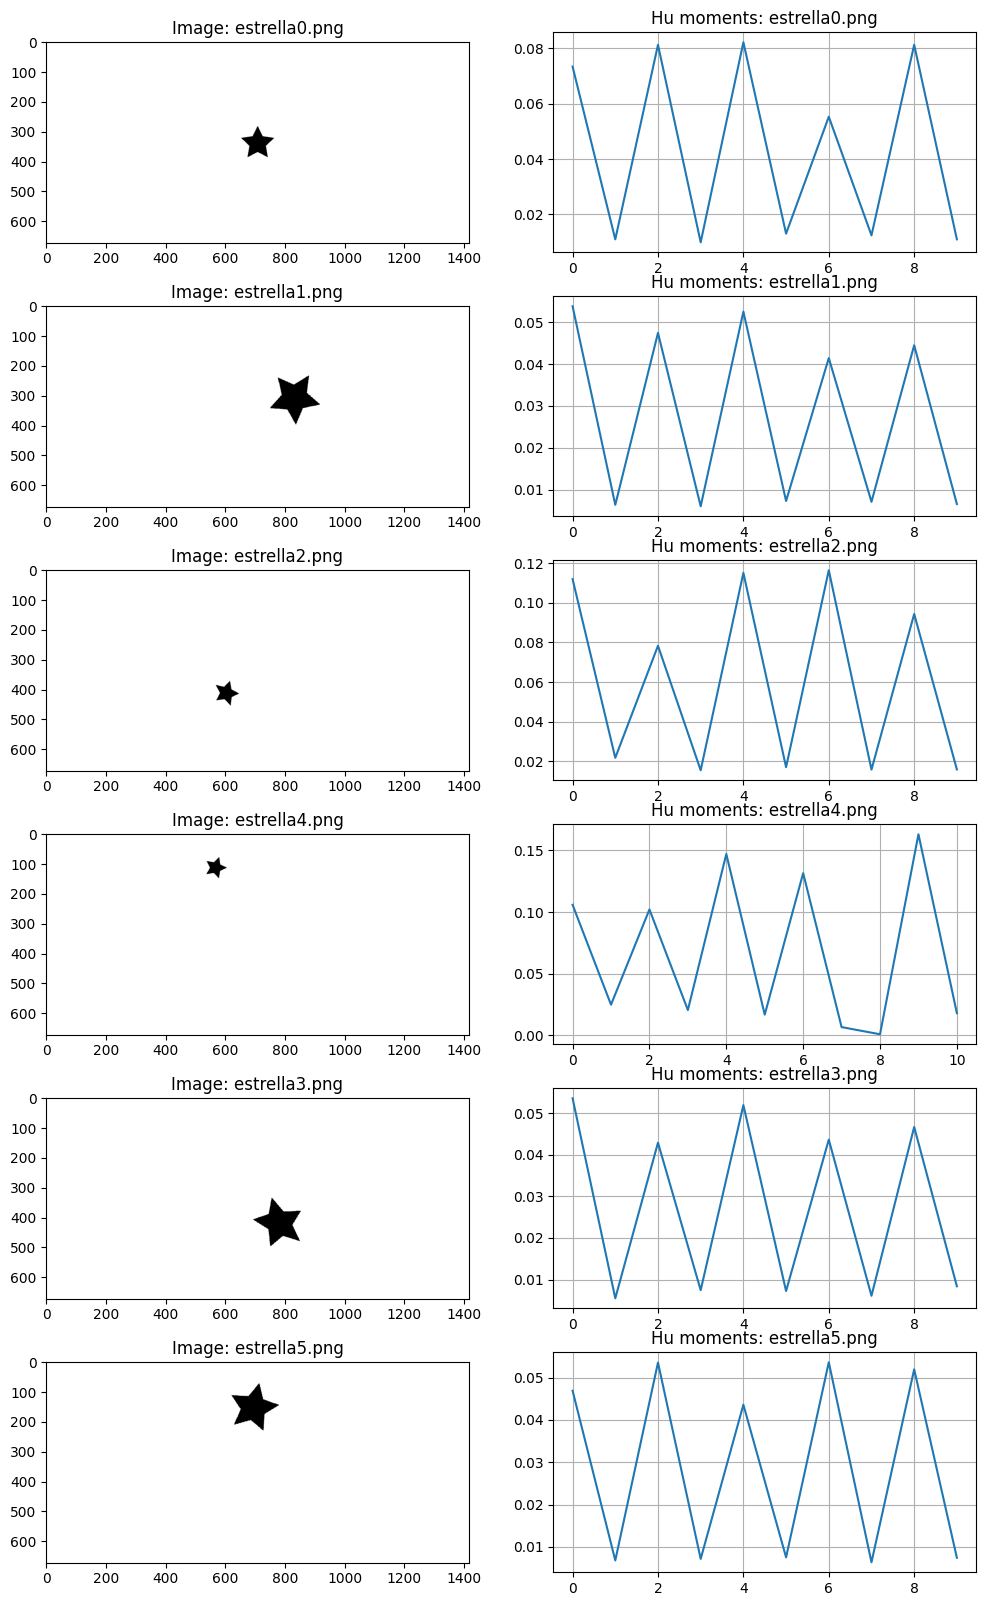

In [413]:
# Ruta de la carpeta que contiene las imágenes de figuras
figure_type_path = data_path + dirs_figuras[2]  # <-- MODIFICAR ['x'] PARA VER OTRA FIGURA

# Lista de imágenes en la carpeta seleccionada
images_list = os.listdir(figure_type_path)

# Configuración de la figura para mostrar las imágenes y los gráficos
plt.figure(figsize=[12, 20])

# Iteración sobre cada imagen en la carpeta
for i in range(len(images_list)):
    # Ruta de la imagen actual
    image_path = os.path.join(figure_type_path, images_list[i])

    if(image_path.endswith('.png')):
        # Lectura de la imagen y conversión a escala de grises
        img = cv2.imread(image_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Aplicación de umbral adaptativo y operaciones de filtrado
        thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

        # Búsqueda de contornos en la imagen
        contornos, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        # Iteración sobre los contornos encontrados
        for contorno in contornos:
            # Aproximación poligonal al contorno
            approx = cv2.approxPolyDP(contorno, 0.01 * cv2.arcLength(contorno, True), True)

        # Cálculo de la función radial
        fr = FR(approx.reshape(-1, 2))

        # Impresión de la imagen actual y los valores de la función radial
        print('Imagen: {}, Valores: {}'.format(images_list[i], fr))

        # Visualización de la imagen actual y su gráfico correspondiente
        plt.subplot(len(images_list), 2, (i+1)*2-1); plt.imshow(img); plt.title('Image: '+images_list[i])

        plt.subplot(len(images_list), 2, (i+1)*2); plt.plot(range(len(fr)), fr); plt.title('Hu moments: '+images_list[i]); plt.grid()

# Mostrar la figura con las imágenes y los gráficos
plt.show()

### Obtenemos los momentos centrales normalizados

Funciones necesarias

In [414]:
# Función para calcular la media de un conjunto de datos
def calculate_mean(datos):
    mean = 0

    # Suma de todos los valores en los datos
    for i in range(len(datos)):
        mean = mean + float(datos[i])

    # Cálculo de la media, si hay datos disponibles; de lo contrario, se asigna un valor predeterminado
    if len(datos) != 0:
        mean = mean / len(datos)
    else:
        mean = 0.1  # Valor por defecto para evitar divisiones por cero

    return mean

# Función para calcular el momento de orden 'r' de un conjunto de datos 'z'
def calculate_moments(z, r):
    N = len(z)

    # Conversión de los datos a valores flotantes
    for i in range(N):
        z[i] = float(z[i])

    # Cálculo de la media y el momento para el orden 'r' especificado
    mu = np.mean(z)
    if N != 0:
        moment = sum((z[i] - mu) ** r for i in range(N)) / N
    else:
        moment = 0.1  # Valor por defecto si no hay datos

    return moment

# Función para calcular momentos normalizados de orden 'r' para un conjunto de datos 'z'
def calculate_normalized_moments(z, r):
    # Cálculo del momento de orden 'r' y el momento cuadrado
    moment = calculate_moments(z, r)
    square_moment = calculate_moments(z, 2)
    square_moment = square_moment ** (r / 2)

    # Cálculo del momento normalizado dividiendo el momento por el momento cuadrado
    norm_moment = moment / square_moment
    return norm_moment

# Función para calcular un vector de características de un conjunto de datos 'z' hasta el orden 'r'
def calculate_vector_characteristics(z, r):
    characteristics = []

    # Cálculo de la media de los datos 'z'
    media = calculate_mean(z)

    # Generación de características hasta el orden 'r'
    for i in range(r):
        if i == 0:
            # Cálculo del primer momento normalizado
            square_moment = calculate_moments(z, 2)
            norm_moment = (square_moment ** 0.5) / media
            characteristics.append(norm_moment)
        else:
            # Cálculo de momentos normalizados para órdenes superiores
            norm_moment = calculate_normalized_moments(z, i)
            characteristics.append(norm_moment)

    return characteristics

In [415]:
# Función para procesar imágenes, calcular momentos normalizados y guardarlos en archivos de texto
def limiares():
    cont = 0
    for figure_type in os.listdir(data_path):
        # Ruta de la carpeta que contiene las imágenes de figuras
        figure_type_path = data_path + figure_type

        # Iteración sobre cada imagen en la carpeta
        for image in os.listdir(figure_type_path):
            # Ruta de la imagen actual
            path = os.path.join(figure_type_path, image)[0:-4]  # Le quitamos la terminación '.png'

            # Verificar si el archivo no existe antes de procesarlo
            if not os.path.exists(path):
                # Lectura de la imagen y procesamiento
                img = cv2.imread(path + ".png")
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (500, 500))
                rows, cols = img.shape

                # Operaciones en la imagen para extraer momentos normalizados
                copy_img = np.zeros((rows, cols))
                blank_img = np.ones((rows, cols)) * 255
                _, copy_img = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY_INV)
                copy_img = cv2.GaussianBlur(copy_img, (5, 5), 0)
                contours, _ = cv2.findContours(copy_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                y = cv2.drawContours(blank_img, contours, -1, (0, 255, 0), 3)

                # Cálculo de momentos normalizados y escritura en un archivo de texto
                moments = cv2.moments(copy_img)
                cx = int(moments['m10'] / (moments['m00'] + 1e-9))
                cy = int(moments['m01'] / (moments['m00'] + 1e-9))
                list_datas = []
                for contour in contours:
                    for point in contour:
                        x, y = point[0]
                        list_datas.append([x - cx, y - cy])
                fr = FR(np.array(list_datas))
                fr = np.nan_to_num(fr)
                fr_norm = (fr - np.mean(fr)) / (np.std(fr) + 1e-9)

                arch = open(path + ".txt", "w")
                for i in range(len(fr_norm)):
                    arch.write(str(fr_norm[i]) + ",")
                arch.write(str(int(cont+1))+"\n")
                arch.close()
        cont += 1
               

# Función para crear un archivo CSV con los momentos normalizados
def crear_csv(path, num_momentos):
    list_data = []
    csv = open(path, "w")

    cont = 0
    for figure_type in os.listdir(data_path):
        # Ruta de la carpeta que contiene las imágenes de figuras
        figure_type_path = data_path + figure_type

        # Iteración sobre cada imagen en la carpeta
        for image in os.listdir(figure_type_path):
            # Ruta de la imagen actual
            path = os.path.join(figure_type_path, image)[0:-4]  # Le quitamos la terminación '.png'
            
            try:
                arch = open(path + ".txt", "r")
            except FileNotFoundError:
                os.mknod(path + ".txt")
                arch = open(path + ".txt", "r")

            data = arch.read()
            data = data.strip("\n").split(",")
            arch.close()
            list_data.append(data)

            norm_mom = calculate_vector_characteristics(data, num_momentos)
            list_data.append(norm_mom)

            for h in range(num_momentos):
                csv.write(str(norm_mom[h]) + ",")
            csv.write(str(int(cont+1))+'\n')
        cont += 1
    csv.close()

### Análisis de resultados
Podemos observar que los resultados de las medidas para entrenamiento y test no son muy altas pero pueden ser capaces de diferenciar entre las distintas figuras propuestas.
Posiblemento con un mayor número de muestras para el entrenamiento nuestro clasificador fuese más fiable.

In [416]:
# Llamada a las funciones para procesar y crear el archivo CSV con momentos normalizados
limiares()
crear_csv('./data/momentosContorno.csv', 50)

### Entrenamos el clasificador y lo testeamos

In [417]:
data = pd.read_csv('./data/momentosContorno.csv')

# Separar las etiquetas de las características
x = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Dividir los datos en conjuntos de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# Crear el clasificador y ajustarlo a los datos de entrenamiento
classifier = LinearDiscriminantAnalysis()
classifier.fit(x_train, y_train)

# Realizar predicciones en los conjuntos de entrenamiento y prueba
y_pred_train = classifier.predict(x_train)
y_pred_test = classifier.predict(x_test)

### Hallamos las medidas de rendimiento para entrenamiento y test: matriz de confusión, accuracy, precision, recall y f1-score

In [419]:
print('**** TRAIN ****')
print('Accuracy: {} %'.format(accuracy_score(y_train, y_pred_train)*100))
print('Precision: {} %'.format(precision_score(y_train, y_pred_train, average='macro')*100))
print('Recall: {} %'.format(recall_score(y_train, y_pred_train, average='macro')*100))
print('F1-score: {} %'.format(f1_score(y_train, y_pred_train, average='macro')*100))
print('Confusion Matrix:\n',(confusion_matrix(y_train, y_pred_train)))
print()
print('**** TEST ****')
print('Accuracy: {} %'.format(accuracy_score(y_test, y_pred_test)*100))
print('Precision: {} %'.format(precision_score(y_test, y_pred_test, average='macro')*100))
print('Recall: {} %'.format(recall_score(y_test, y_pred_test, average='macro')*100))
print('F1-score: {} %'.format(f1_score(y_test, y_pred_test, average='macro')*100))
print('Confusion Matrix:\n',confusion_matrix(y_test, y_pred_test))

**** TRAIN ****
Accuracy: 69.73684210526315 %
Precision: 75.17263986013987 %
Recall: 68.71527777777777 %
F1-score: 69.78856002883462 %
Confusion Matrix:
 [[ 7  0  1  0  0  0  0  0]
 [ 0  4  1  4  0  0  0  0]
 [ 0  0  6  2  0  2  0  0]
 [ 0  0  2 10  0  0  0  0]
 [ 0  0  0  0 10  0  0  0]
 [ 0  0  2  0  0  4  1  2]
 [ 0  0  1  0  0  2  4  1]
 [ 0  0  0  0  0  2  0  8]]

**** TEST ****
Accuracy: 52.63157894736842 %
Precision: 56.4625850340136 %
Recall: 61.9047619047619 %
F1-score: 54.920634920634924 %
Confusion Matrix:
 [[2 0 1 0 0 0 0]
 [0 2 1 0 0 0 0]
 [0 0 2 0 0 0 0]
 [0 0 0 2 0 0 0]
 [0 0 2 0 0 1 0]
 [0 0 1 0 2 0 1]
 [0 0 0 0 0 0 2]]
